# Face Recognition using Principal Component Analysis

This project will use the statistical technique of Principal Component Analysis (PCA) to generate eigenfaces and employ them to implement a mini face recognition system.

This project has 2 phases:

1. Use PCA to generate eigenfaces and then reconstruct original face images by linearly combining eigenfaces. This phase includes:
- Divide data into a training and test set.
- Perform PCA on the training set.
- Display the Eigenfaces.
- Display the reconstruction of a face from the ORL database using top-k eigenfaces. Different values of k will be employed.

2. Implement a mini face recognition system. This phase includes:
 - Use eigencoefficients as a feature for each face image.
 - In the training phase, collect all eigencoefficients and corresponding identity label.
 - In the testing phase, compute eigencoefficient of the test image and find the closest eigencoefficient from the training phase to determine the identity of the test image.

This project will use the ORL face database (stored in the folder `att_faces` that is included along with this notebook). It contains 40 sub-folders, one for each of the 40 subjects/persons. For each person, there are ten images in the appropriate folder. The images are of size 92 by 110 each. Each image is in the pgm format. Though the face images are in different poses, expressions, and facial accessories, they are all roughly aligned (the eyes are in roughly similar locations in all images).

In [1]:
import scipy.ndimage as ndi
import numpy as np
import skimage
from skimage import io
from skimage import data, img_as_float
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import os, glob, math

## Part A: Load all images from from directory `att_faces` and split into trainning and test data

In [2]:
# Set up some known constants and directory to store images and labels
N = 40*10; #Total images in directory att_faces
d = 112*92; #They all have same size
A = np.zeros((N,d)); #Store all the images row wise in A
labels = np.zeros(N,)

#load all images from directory 'att_faces'
'''
This functions loads all images from each of the 40 directories in the folder 'att_faces'
It uses a nested loop to first iterate over all directories and
then to iterate over all images in each directory.
Do not forget to convert each image into float.
Return a numpy array of shape (N,d) containing all images and a numpy array of shape (N,)
containing corresponding labels (an integer to represent identity of the person)
'''
def loadData():
    imgDir = 'att_faces'
    dirname = os.path.join(os.getcwd(),imgDir)

    # Initialize label and photo counters. Label counter starts at -1 since first label is 0.
    # Photo counter starts at 0 since it is not incremented until after it is used
    current_label = -1
    photo_count = 0

    # Go through each person (each file of s1, s2, etc.)
    for each_person in glob.glob(dirname + "/*"):
        # Check that the directory of each person is a valid person
        if os.path.isdir(each_person):
            # Set the label for this current person
            current_label += 1

            # Iterate through each image for each person, grabbing their directory and getting
            # each image, opening them, putting them the image array, ensuring they are float
            # images and unravel them. Add the label for each image (should be the same for
            # each person).
            for each_file in glob.glob(each_person + "/*.pgm"):
                A[photo_count] = img_as_float(io.imread(each_file)).ravel()
                labels[photo_count] = current_label
                photo_count += 1

    return (A, labels)

(A, labels) = loadData()

# Split the dataset into training and test making the test set to be 40% of the entire dataset.
data_train, data_test, labels_train, labels_test = train_test_split(A, labels, test_size=0.4, random_state=42, stratify = labels)

print("Trainning Data Shape: ", data_train.shape)
print("Trainning Data Labels Shape: ", labels_train.shape)

print("Testing Data Shape: ", data_test.shape)
print("Testing Data Labels Shape: ", labels_test.shape)

nTrain = data_train.shape[0]
nTest = data_test.shape[0]

Trainning Data Shape:  (240, 10304)
Trainning Data Labels Shape:  (240,)
Testing Data Shape:  (160, 10304)
Testing Data Labels Shape:  (160,)


Average Data Minimum:  0.22671568627451
Average Data Mean:     0.4416655582069785


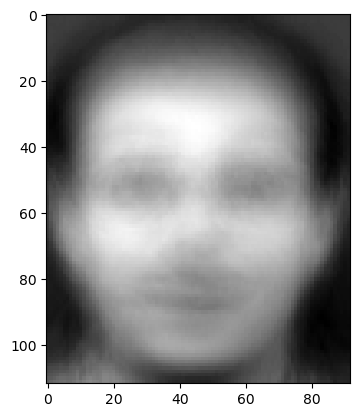

In [3]:
def computeAverage(data):
    '''
    Computes the average of the input data along the rows. Resulting shape is (d, )
    Returns the average after reshaping it into (112, 92)
    '''
    # Get the average data
    avg_data = np.average(data, 0).reshape(112,92)

    # Print to show closeness
    print("Average Data Minimum: ", avg_data.min())
    print("Average Data Mean:    ", avg_data.mean())

    return avg_data

#Get the mean face (average of all faces)
averageFace = computeAverage(data_train)

plt.imshow(averageFace, cmap = 'gray')

## Part B: Perform PCA
[sklearn.decomposition.PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)



In [4]:
'''
Performs PCA on the input data_train keeping n_components principal components.
Returns in a tuple:
    the eigencoefficients for data_train (i.e. the projection of data onto the principal components)
    and the instance of the PCA object created
'''
def doPCA(data_train, n_components):
    # Start the pca and fit the data. Then get the eigencoefficents
    pca = PCA(n_components=n_components, random_state=42).fit(data_train)
    eigco = pca.fit_transform(data_train)

    return (eigco, pca)

#Let us perform PCA on data_train keeping only the top 25 principal components
numPC = 25
eigencoeffs_train, principal = doPCA(data_train, numPC)

## How much each feature impacts the prediction?
The explained variance, or eigenvalue, in PCA shows the variance that can be attributed to each of the principal components.

It is an array of values where each value equals the variance of each principal component and the length of the array is equal to the number of components defined with `n_components`.

It can be accessed with the `.explained_variance_` notation.

[Source](https://www.jcchouinard.com/pca-with-python/#How_much_each_feature_impacts_the_prediction)

The bar plot of explained variance, in combination with its cumulative sum, indicates which of the eigenvectors (principal components) are most important. The exaplained variance is already sorted in decreasing order.

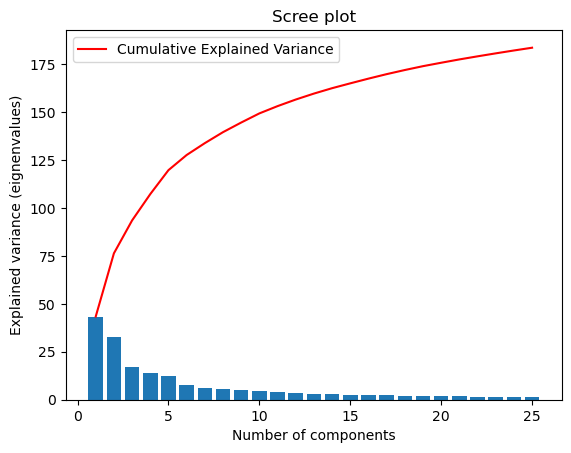

In [5]:
# Bar plot of explained_variance
plt.bar(
    range(1,len(principal.explained_variance_)+1),
    principal.explained_variance_
    )

plt.plot(
    range(1,len(principal.explained_variance_ )+1),
    np.cumsum(principal.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')

plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')

plt.show()


It can be seen from this graph that, visually, top 10 eigenvectors capture (explain) most of the variance in the data. By normalizing the plot with the total variance, the above plot can show how many components explain "most" of the variance.

## Part C: Plot top 25 Eigenfaces

In this part, the goal is to find and display the top 25 eigenfaces:


## Eigenfaces


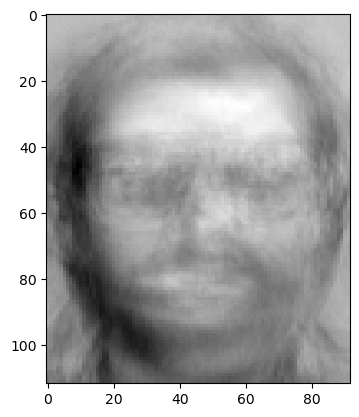

In [6]:
# Uses the components_ method of the PCA object to access the eigenvectors (principal components).
# Once reshaped to the image size, these eigenvectors are called EigenFaces.
def getEigenface(principal, img_num):
    # Get the eigen face
    return principal.components_[img_num].reshape(112,92)

eigFace = getEigenface(principal, 4)
plt.imshow(eigFace, cmap = 'gray')

Create a 5 x 5 plot that shows the top 25 eigenfaces

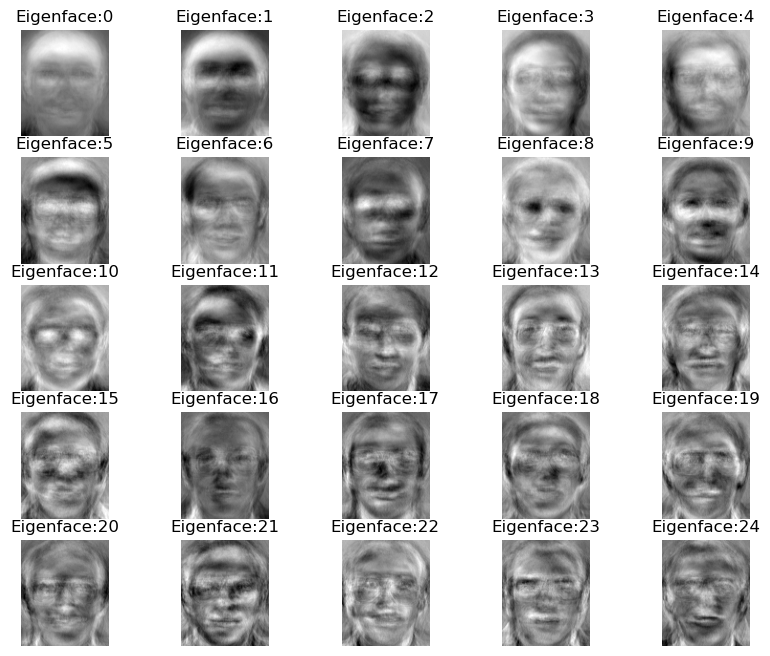

In [7]:
# Create the subplots
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(10, 8), sharex = True, sharey = True)

# Counter for each of the 25 images
img_count = 0

# Loop through each column and in each row
for i in range(5):
    for j in range(5):
        # Get the next face, set the title, and display
        eigFace = getEigenface(principal, img_count)
        ax[i][j].set_title("Eigenface:"+ str(img_count))
        ax[i][j].axis('off')
        ax[i][j].imshow(eigFace, cmap = 'gray')
        img_count += 1


## Part D: Reconstruction of individual faces from top-k eigenFaces

In this part, the goal is to reconstruct a face image from different number of eigenfaces.

Before we reconstruct individual faces from eigenfaces, let us recompute the PCA but this time keeping all the principal components. That way we will have access to all the eigenfaces (and we can choose the top-k ones from which to reconstruct).

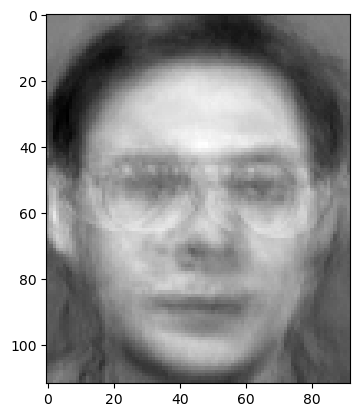

In [8]:
#do PCA with nTrain components
numPC = nTrain
eigencoeffs_train, principal = doPCA(data_train, numPC)

#Compute the mean of training images (to be used soon)
data_train_mean = data_train.mean(axis = 0)

#reconstruction using top k eigenvectors
'''
This function reconstructs a training image at index imageIndex using the top k eigenvectors.
Reconstructed image is simply the linear combination of the top-k eigenvectors
                with top-k eigencoefficients (corresponding to the image at index imageIndex)
                + the average face.
Returns the reconstructed image.
'''
def reconstruct(averageFace, eigenvectors, eigencoeffs_train, k, imageIndex):
    assert eigenvectors.shape == (nTrain, d)
    assert (eigencoeffs_train.shape == (nTrain, numPC))

    # If we want the 10th image then we need to decrement from 10 to 9 to
    # access the array correctly
    imageIndex -= 1

    # Initialize size and use the average face values to start
    result = averageFace.copy()

    # Calculate the reconstructed face from 0 to k (using the top k values)
    for top_k in range(k):
        result += eigencoeffs_train[imageIndex][top_k] * eigenvectors[top_k]

    return result.reshape(112, 92)

#reconstruct the 10th training image with top-50 eigenvectors
recons = reconstruct(data_train_mean, principal.components_, eigencoeffs_train, 50, 10 )
plt.imshow(recons, cmap = 'gray')

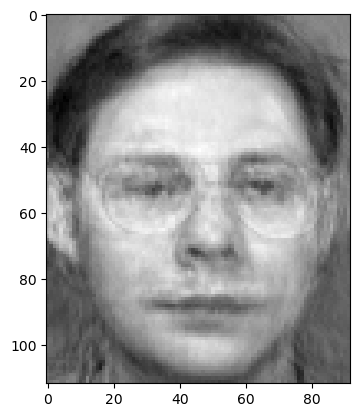

In [9]:
#reconstruct the 10th training image with top-150 eigenvectors
recons1 = reconstruct(data_train_mean, principal.components_, eigencoeffs_train, 150, 10 )
plt.imshow(recons1, cmap = 'gray')

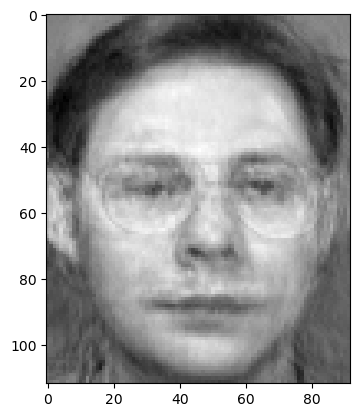

In [10]:
#reconstruct the 150th training image with all eigenvectors
imageIndex = 150
recons2 = reconstruct(data_train_mean, principal.components_, eigencoeffs_train, numPC, imageIndex )
plt.imshow(recons1, cmap = 'gray')

Create a 3 x 3 plot that shows the reconstructed face for the 10th training image

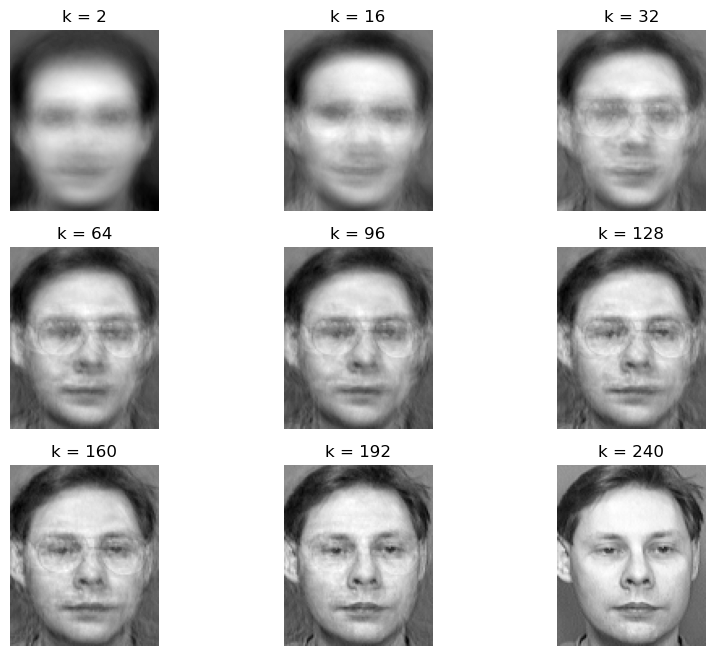

In [11]:
#Plot for several different values of k
reconsk = [2, 16, 32, 64, 96, 128, 160, 192, 240]

# Plot a 3x3 grid of the reconstructed face for the 10th training image for different values
# of k in the array reconsk
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(10, 8), sharex = True, sharey = True)
rec_count = 0
for row in range(3):
    for col in range(3):
        k_val = reconsk[rec_count]
        recon = reconstruct(data_train_mean, principal.components_, eigencoeffs_train, k_val, 10 )
        ax[row][col].set_title("k = " + str(k_val))
        ax[row][col].axis('off')
        ax[row][col].imshow(recon, cmap = 'gray')
        rec_count += 1

## Part E: Face recognition

Perform face recognition by comparing eigen-coefficients of the images in the test set with the eigen-coefficients of the images in the training set.

Use the `transform` method of the PCA object to derive eigen-coefficients of the test set.

Then, write a function that, for each test image, finds the label of the closest training image using the top-k eigenvectors.

In [12]:
#do PCA with nTrain components
numPC = nTrain
eigencoeffs_train, principal = doPCA(data_train, numPC)

eigencoeffs_test = principal.transform(data_test)

'''
For each test image, finds the label of the closest training image by computing the
SSD between the topk eigencoefficients of the test image, and all training images.

Returns a numpy array of predictions with shape (nTest, )
'''
def getPrediction(k):
    # Grab the number of tests and the number of training images
    nTest, _ = eigencoeffs_test.shape
    nTrain, _ = eigencoeffs_train.shape

    # Initialize the predictions np array
    predictions = np.zeros((nTest,), dtype = int)

    # For each test, find the ssd of the training data and the test data. Then find the
    # the training labels at the minimum of the ssd and put into the predictions array
    for i in range(nTest):
        SSD = np.sum((eigencoeffs_train[:, :k] - eigencoeffs_test[i, :k]) ** 2, axis=1)
        predictions[i] = labels_train[np.argmin(SSD)]

    return predictions

In [13]:
#Find predictions using top-10 eigenvectors
predicted_test = getPrediction(10)
acc = accuracy_score(labels_test, predicted_test, normalize=False)
print("Accuracy =", acc, "out of", nTest)

Accuracy = 147 out of 160


In [14]:
#Find predictions using top-50 eigenvectors
predicted_test = getPrediction(50)
acc = accuracy_score(labels_test, predicted_test, normalize=False)
print("Accuracy =", acc, "out of", nTest)

Accuracy = 151 out of 160


In [15]:
#Find predictions using all eigenvectors
predicted_test = getPrediction(numPC)
acc = accuracy_score(labels_test, predicted_test, normalize=False)
print("Accuracy =", acc, "out of", nTest)

Accuracy = 152 out of 160


Visualize the confusion matrix. Can you figure out which face images were misclassified?

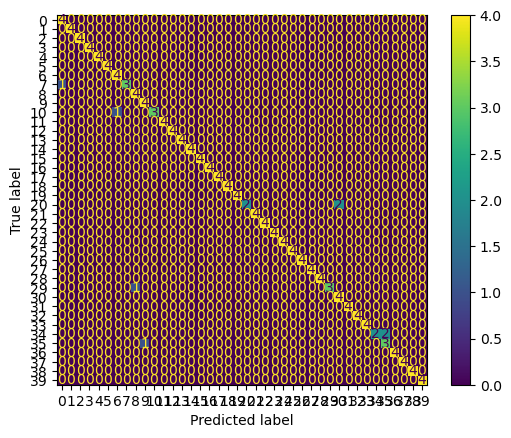

In [16]:
cm = confusion_matrix(labels_test, predicted_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Summary
Plot the accuracy for different values of `k`. Note, how quickly the accuracy saturates. In other words, a high accuracy is achieved for low values of `k`

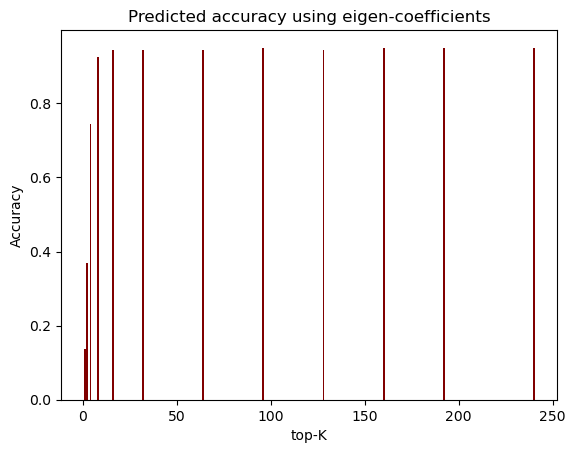

In [17]:
topk_values = [1, 2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 240]

scores = np.zeros(len(topk_values),)
for i, k in enumerate(topk_values):
    predicted_test = getPrediction(k)
    scores[i] = accuracy_score(labels_test, predicted_test)

plt.bar(topk_values, scores, color ='maroon',
        width = 1)
plt.xlabel("top-K")
plt.ylabel("Accuracy")
plt.title("Predicted accuracy using eigen-coefficients")
plt.show()